In [ ]:
# Install required libraries (run once in Colab)
!pip install xgboost opencv-python scikit-learn matplotlib seaborn --quiet

# Imports
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
import seaborn as sns
from google.colab import files
import time
import shutil
import joblib
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# ---------- Config ----------
IMG_SIZE = (224, 224)
SEED = 42
BATCH_SIZE = 64

In [ ]:
# ---------- Feature extractor ----------
print("Loading MobileNetV2 feature extractor...")
base_model = MobileNetV2(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
base_model.trainable = False
print("Feature extractor ready.\n")

Loading MobileNetV2 feature extractor...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature extractor ready.



In [ ]:
# ---------- Helper: extract_features ----------
def extract_features(image_paths):
    """
    Given a list of image file paths, returns a numpy array of extracted features.
    Uses global `feature_extractor` and global IMG_SIZE.
    """
    features = []
    for i, img_path in enumerate(image_paths):
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Could not read image: {img_path}")

            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_input(img.astype(np.float32))
            img = np.expand_dims(img, axis=0)  # shape (1, H, W, 3)

            feat = feature_extractor.predict(img, verbose=0)  # shape (1, h, w, c)
            feat = np.mean(feat, axis=(1, 2)).flatten()       # shape (c,)
            features.append(feat)
        except Exception as e:
            print(f"[Warning] Error processing {img_path}: {e}")
            continue

        if (i + 1) % 50 == 0:
            print(f"Processed {i+1}/{len(image_paths)} images in this batch")

    if len(features) == 0:
        # Return empty array with shape (0, feature_dim) if we can get feature_dim, else (0,0)
        return np.zeros((0, 0))
    return np.vstack([f.reshape(1, -1) for f in features])  # shape (n, feat_dim)

In [ ]:
# ---------- Prepare dataset ----------
def prepare_dataset(dataset_path):
    image_paths = []
    labels = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))

    if len(image_paths) == 0:
        raise ValueError("No images found in the dataset directory. Check folder structure.")

    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    class_names = le.classes_
    print(f"Total images found: {len(image_paths)}")
    print(f"Classes: {class_names}")
    return image_paths, encoded_labels, le, class_names

In [ ]:
# ---------- Upload & extract dataset (Colab) ----------
print("\nUpload a ZIP file containing folders (each folder = class).")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded. Please upload the ZIP dataset in Colab.")

zip_filename = list(uploaded.keys())[0]
print(f"Uploaded: {zip_filename}")

dataset_path = '/content/dataset'
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
os.makedirs(dataset_path, exist_ok=True)

print("Extracting dataset...")
with zipfile.ZipFile(zip_filename, 'r') as zf:
    zf.extractall(dataset_path)
print("Extraction done.")


Upload a ZIP file containing folders (each folder = class).


Saving Tomato_Leaf_Disease.zip to Tomato_Leaf_Disease.zip
Uploaded: Tomato_Leaf_Disease.zip
Extracting dataset...
Extraction done.


In [ ]:
# ---------- Build dataset (paths + labels) ----------
image_paths, y, le, class_names = prepare_dataset(dataset_path)

# ---------- Feature extraction in batches ----------
print("\nStarting feature extraction (this can take time)...")
start_time = time.time()
all_features = []
feat_dim = None

for i in range(0, len(image_paths), BATCH_SIZE):
    batch_paths = image_paths[i:i+BATCH_SIZE]
    batch_feats = extract_features(batch_paths)

    if batch_feats.size == 0:
        print(f"[Warning] Batch {i//BATCH_SIZE + 1} produced no features — skipping.")
        continue

    if feat_dim is None:
        feat_dim = batch_feats.shape[1]

    # sanity: ensure feature dim consistent
    if batch_feats.shape[1] != feat_dim:
        raise ValueError("Feature dimension changed between batches")

    all_features.append(batch_feats)
    print(f"Completed batch {i//BATCH_SIZE + 1} / { (len(image_paths)-1)//BATCH_SIZE + 1 }")

if len(all_features) == 0:
    raise RuntimeError("No features extracted from any image. Check files and preprocessing.")

X = np.vstack(all_features)
print(f"Feature extraction finished in {time.time()-start_time:.2f}s. Feature shape: {X.shape}")

Total images found: 11000
Classes: ['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']

Starting feature extraction (this can take time)...
Processed 50/64 images in this batch
Completed batch 1 / 172
Processed 50/64 images in this batch
Completed batch 2 / 172
Processed 50/64 images in this batch
Completed batch 3 / 172
Processed 50/64 images in this batch
Completed batch 4 / 172
Processed 50/64 images in this batch
Completed batch 5 / 172
Processed 50/64 images in this batch
Completed batch 6 / 172
Processed 50/64 images in this batch
Completed batch 7 / 172
Processed 50/64 images in this batch
Completed batch 8 / 172
Processed 50/64 images in this batch
Completed batch 9 / 172
Processed 50/64 images in this batch
Completed batch 10 / 172
Processed

In [ ]:
# ---------- Split dataset ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")


Training samples: 8800
Testing samples:  2200


In [ ]:
# ---------- Train XGBoost ----------
print("\nTraining XGBoost classifier...")
params = {
    'objective': 'multi:softmax',
    'num_class': len(class_names),
    'learning_rate': 0.05,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss',
    'seed': SEED,
    'use_label_encoder': False,
    'tree_method': 'hist'
}

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)
print("Training finished.")

# ---------- Evaluate ----------
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Training XGBoost classifier...
Training finished.
Test accuracy: 0.8500

Classification report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.86      0.86      0.86       220
                        Tomato___Early_blight       0.80      0.66      0.72       220
                         Tomato___Late_blight       0.87      0.85      0.86       220
                           Tomato___Leaf_Mold       0.84      0.85      0.85       220
                  Tomato___Septoria_leaf_spot       0.79      0.82      0.80       220
Tomato___Spider_mites Two-spotted_spider_mite       0.84      0.83      0.84       220
                         Tomato___Target_Spot       0.71      0.84      0.77       220
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.95      0.96       220
                 Tomato___Tomato_mosaic_virus       0.93      0.94      0.94       220
                             Tom

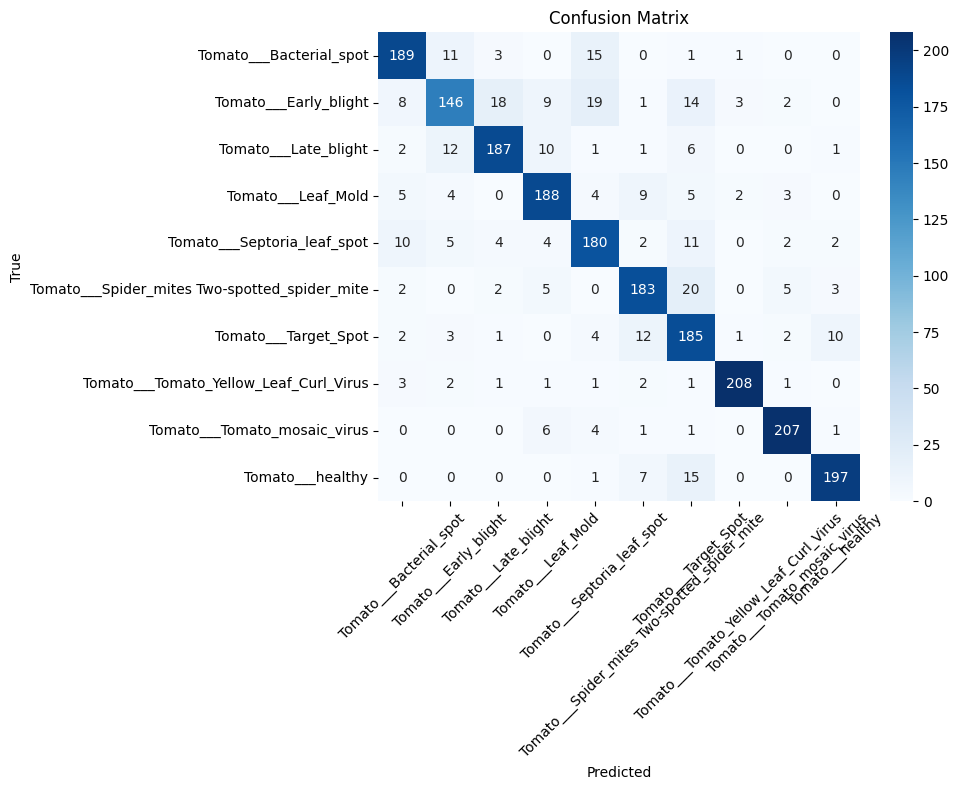

In [ ]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
# ---------- Save model and encoder ----------
model.save_model('xgboost_tomato_model.json')
joblib.dump(le, 'label_encoder.pkl')
print("Saved: xgboost_tomato_model.json, label_encoder.pkl, confusion_matrix.png")

# Offer files for download in Colab
files.download('xgboost_tomato_model.json')
files.download('label_encoder.pkl')
files.download('confusion_matrix.png')

Saved: xgboost_tomato_model.json, label_encoder.pkl, confusion_matrix.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ---------- Prediction helper ----------
def predict_disease(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Image not loaded", 0.0

    feats = extract_features([image_path])
    if feats.size == 0:
        return "Error: Feature extraction failed", 0.0

    pred = model.predict(feats)
    proba = model.predict_proba(feats)
    class_idx = int(pred[0])
    class_name = le.inverse_transform([class_idx])[0]
    confidence = float(np.max(proba))

    # Show image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,5)); plt.imshow(img_rgb); plt.axis('off')
    plt.title(f"Prediction: {class_name}  (Confidence: {confidence:.2f})")
    plt.show()
    return class_name, confidence



Upload one test image (or cancel to skip):


Saving Tomato Diseased Leaf.jpeg to Tomato Diseased Leaf (1).jpeg


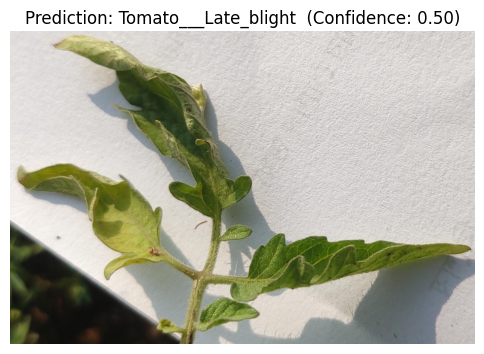

Result: Tomato___Late_blight (confidence 49.89%)


In [ ]:
# ---------- Test on a single uploaded image (example) ----------
print("\nUpload one test image (or cancel to skip):")
uploaded_test = files.upload()
if uploaded_test:
    test_img_name = list(uploaded_test.keys())[0]
    cls, conf = predict_disease(test_img_name)
    print(f"Result: {cls} (confidence {conf:.2%})")
else:
    print("No test image uploaded — skipping interactive test.")